# Parameter Inference

Here we infer the parameters of the systems we have observed.  Because of the use of print statements in `infer.py`, this notebook must be opened in Python 3 mode.

In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import infer
import pymc3 as pm
import scipy.stats as ss
import seaborn as sns
import sys
import theano
import theano.tensor as tt
import theano.tensor.extra_ops as te
from tqdm import tqdm_notebook
from true_params import uncert

p = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
try:
    sys.path.index(p)
except ValueError:
    sys.path.append(p)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

We will want to impose a prior on $\Theta$ that is about right.  A Gaussian gets pretty close:

In [5]:
mu_t = mean(vt.thetas)
sigma_t = std(vt.thetas)

Surprisingly, this is pretty good:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


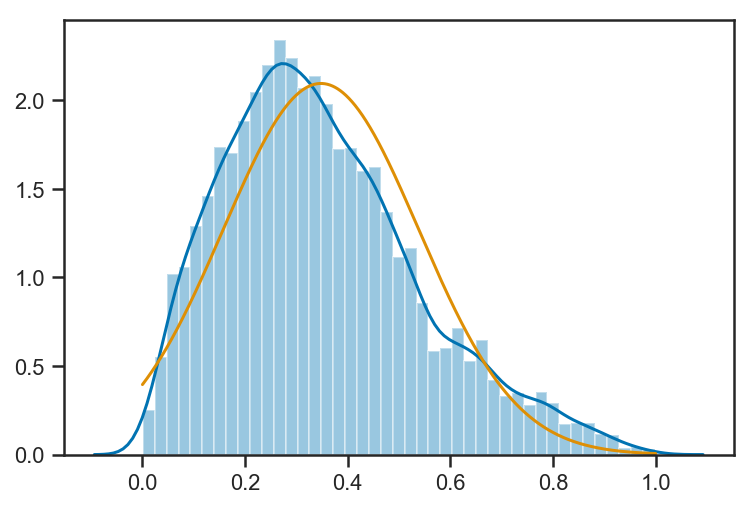

In [6]:
sns.distplot(vt.thetas)
xs = linspace(0, 1, 1000)
plot(xs, ss.norm(loc=mu_t, scale=sigma_t).pdf(xs))

In [11]:
i = 544

with infer.m:
    infer.mco.set_value(infer.mcobs[i])
    infer.eto.set_value(infer.etaobs[i])
    infer.ro.set_value(infer.rhoobs[i])
    infer.to.set_value(infer.thetaobs[i])

    infer.sigma_mc.set_value(infer.smcs[i])
    infer.sigma_eta.set_value(infer.sets[i])
    infer.sigma_rho.set_value(infer.srhs[i])
    infer.sigma_theta.set_value(infer.sths[i])
    
    trace = pm.sample(draws=1000, tune=1000, njobs=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, dl, eta, mcdet]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:09<00:00, 825.50draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` inst

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d454748>,
      dtype=object)

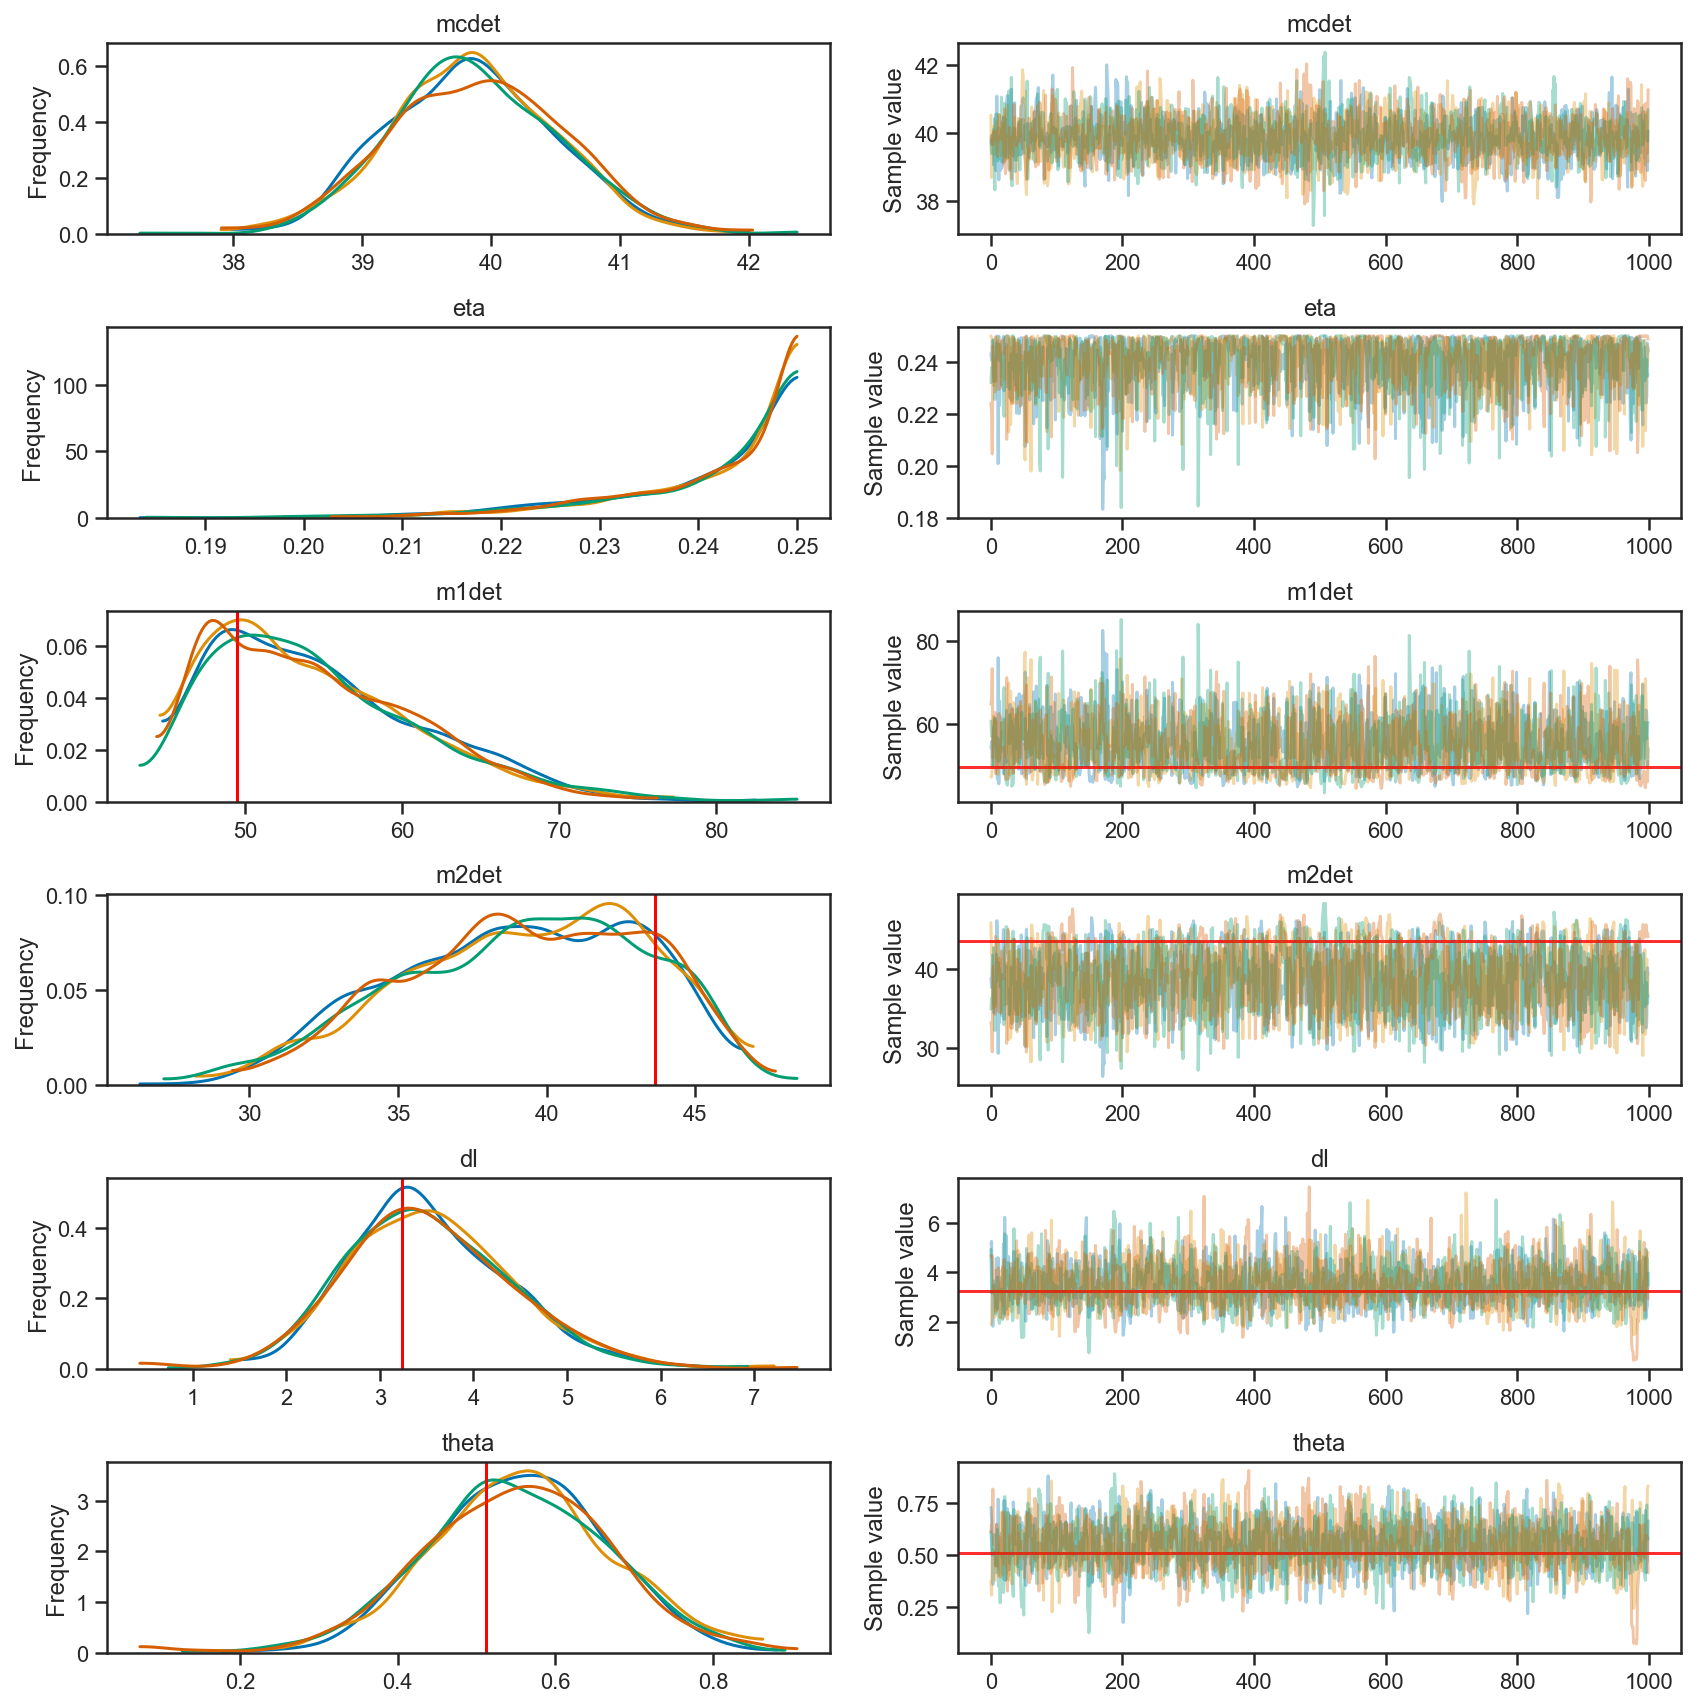

In [13]:
pm.traceplot(trace, lines={'m1det': infer.m1s[i]*(1+infer.zs[i]), 'm2det': infer.m2s[i]*(1+infer.zs[i]), 'dl': Planck15.luminosity_distance(infer.zs[i]).to(u.Gpc).value, 'theta': infer.thetas[i]})